**Covid 19 Datat**

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import os
import random
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from scipy.stats import skew
import warnings

# Configure plotly template
pio.templates.default = "plotly_dark"

# Set seaborn style
sns.set_style("whitegrid")

# Filter warnings
warnings.filterwarnings('ignore')

# Set plot size
plt.rcParams["figure.figsize"] = (7,4)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.0f}'.format)

In [40]:
cleaned_data = pd.read_csv('covid_19_clean_complete.csv')
cleaned_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,34,68,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41,20,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28,2,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,43,2,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11,18,2020-01-22,0,0,0,0,Africa


**Data Preprocessing**

In [41]:
cleaned_data.rename(columns={'ObservationDate': 'date',
                     'Province/State':'state',
                     'Country/Region':'country',
                     'Last Update':'last_updated',
                     'Confirmed': 'confirmed',
                     'Deaths':'deaths',
                     'Recovered':'recovered'
                    }, inplace=True)

# cases AAAA
cases = ['confirmed', 'deaths', 'recovered', 'active']

# Active Case = confirmed - deaths - recovered
cleaned_data['active'] = cleaned_data['confirmed'] - cleaned_data['deaths'] - cleaned_data['recovered']

# replacing Mainland china with just China
cleaned_data['country'] = cleaned_data['country'].replace('Mainland China', 'China')

# filling missing values
cleaned_data[['state']] = cleaned_data[['state']].fillna('')
cleaned_data[cases] = cleaned_data[cases].fillna(0)
cleaned_data.rename(columns={'Date':'date'}, inplace=True)

In [42]:
# Convert the 'date' column to the date type
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Print the date range
print("External cleaned_data")
print(f"Earliest Entry: {cleaned_data['date'].min()}")
print(f"Last Entry:     {cleaned_data['date'].max()}")
print(f"Total Days:     {(cleaned_data['date'].max() - cleaned_data['date'].min()).days}")


External cleaned_data
Earliest Entry: 2020-01-22 00:00:00
Last Entry:     2020-07-27 00:00:00
Total Days:     187


state: The state or province where the data is located.

country: The country to which the data belongs.

Lat: Latitude information.

Long: Longitude information.

date: Date information.

confirmed: Number of confirmed cases.

deaths: Number of deaths.

recovered: Number of recovered individuals.

Active: Number of active cases.

WHO Region: Region designated by the World Health Organization (WHO).

active: Active status (usually refers to the number of active cases).


In [43]:
new_columns = {
    'state': 'State',
    'country': 'Country',
    'Lat': 'Latitude',
    'Long': 'Longitude',
    'date': 'Date',
    'confirmed': 'Confirmed',
    'deaths': 'Deaths',
    'recovered': 'Recovered',
    'Active': 'Active',
    'WHO Region': 'WHO Region',
    'active': 'Active Status'
}

cleaned_data.rename(columns=new_columns, inplace=True)


In [44]:
cleaned_data.sample(1)

,State,Country,Latitude,Longitude,Date,Confirmed,Deaths,Recovered,Active,WHO Region,Active Status
38941,Gansu,China,36,104,2020-06-19,151,2,137,12,Western Pacific,12


In [45]:
# To obtain a general profile of the dataset
# Number of observations - data types - number of null values - number of unique values - minimum-maximum values
# Null values are displayed as "0"!

def summary(data, pred=None):
    obs = data.shape[0]
    Types = data.dtypes
    Counts = data.apply(lambda x: x.count())
    Min = data.min()
    Max = data.max()
    Uniques = data.apply(lambda x: x.unique().shape[0])
    Nulls = data.apply(lambda x: x.isnull().sum())
    print('Data shape:', data.shape)
    print('-------------------')
    nul = data.isnull().sum()
    if (nul == 0).all():
        print("Null values are 0")
    else:
        for column, count in nul.items():
            if count != 0:
                print(f"Number of {column}: {count}")

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis=1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

summary(cleaned_data)


Data shape: (49068, 11)
-------------------
Null values are 0
___________________________
Data Types:
Types
int64             5
object            3
float64           2
datetime64[ns]    1
Name: count, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
Active,int64,49068,8641,0,-14,2816444
Active Status,int64,49068,8641,0,-14,2816444
Confirmed,int64,49068,10861,0,0,4290259
Country,object,49068,187,0,Afghanistan,Zimbabwe
Date,datetime64[ns],49068,188,0,2020-01-22 00:00:00,2020-07-27 00:00:00
Deaths,int64,49068,3640,0,0,148011
Latitude,float64,49068,260,0,-52,72
Longitude,float64,49068,261,0,-135,178
Recovered,int64,49068,7609,0,0,1846641
State,object,49068,79,0,,Zhejiang


In [46]:
country_wise_latest = pd.read_csv("/content/country_wise_latest.csv")
data = country_wise_latest.copy()
data.head(5)

,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region
0,Afghanistan,36263,1269,25198,9796,106,10,18,4,69,5,35526,737,2,Eastern Mediterranean
1,Albania,4880,144,2745,1991,117,6,63,3,56,5,4171,709,17,Europe
2,Algeria,27973,1163,18837,7973,616,8,749,4,67,6,23691,4282,18,Africa
3,Andorra,907,52,803,52,10,0,0,6,89,6,884,23,3,Europe
4,Angola,950,41,242,667,18,1,0,4,25,17,749,201,27,Africa


In [47]:
new_columns = {
    "Country/Region": "Country",
    "Confirmed": "Confirmed",
    "Deaths": "Deaths",
    "Recovered": "Recovered",
    "Active": "Active",
    "New cases": "New Cases",
    "New deaths": "New Deaths",
    "New recovered": "New Recovered",
    "Deaths / 100 Cases": "Deaths (per 100 Cases)",
    "Recovered / 100 Cases": "Recovered (per 100 Cases)",
    "Deaths / 100 Recovered": "Deaths (per 100 Recovered)",
    "Confirmed last week": "Confirmed last week",
    "1 week change": "1 week change",
    "1 week % increase": "1 week % increase",
    "WHO Region": "WHO Region"
}

# Rename columns
data.rename(columns=new_columns, inplace=True)


In [48]:
data.sample(1)

,Country,Confirmed,Deaths,Recovered,Active,New Cases,New Deaths,New Recovered,Deaths (per 100 Cases),Recovered (per 100 Cases),Deaths (per 100 Recovered),Confirmed last week,1 week change,1 week % increase,WHO Region
63,Gambia,326,8,66,252,49,2,6,2,20,12,112,214,191,Africa


In [49]:
# To obtain a general profile of the dataset
# Number of observations - data types - number of null values - number of unique values - minimum-maximum values
# Null values are displayed as "0"!

def summary(data, pred=None):
    obs = data.shape[0]
    Types = data.dtypes
    Counts = data.apply(lambda x: x.count())
    Min = data.min()
    Max = data.max()
    Uniques = data.apply(lambda x: x.unique().shape[0])
    Nulls = data.apply(lambda x: x.isnull().sum())
    print('Data shape:', data.shape)
    print('-------------------')
    nul = data.isnull().sum()
    if (nul == 0).all():
        print("Null values are 0")
    else:
        for column, count in nul.items():
            if count != 0:
                print(f"Number of {column}: {count}")

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis=1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

summary(data)


Data shape: (187, 15)
-------------------
Null values are 0
___________________________
Data Types:
Types
int64      9
float64    4
object     2
Name: count, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
1 week % increase,float64,187,169,0,-4,226
1 week change,int64,187,162,0,-47,455582
Active,int64,187,173,0,0,2816444
Confirmed,int64,187,184,0,10,4290259
Confirmed last week,int64,187,183,0,10,3834677
Country,object,187,187,0,Afghanistan,Zimbabwe
Deaths,int64,187,150,0,0,148011
Deaths (per 100 Cases),float64,187,145,0,0,29
Deaths (per 100 Recovered),float64,187,155,0,0,inf
New Cases,int64,187,122,0,0,56336


In [50]:
Region = data.groupby(by='WHO Region').sum()
Region

,Country,Confirmed,Deaths,Recovered,Active,New Cases,New Deaths,New Recovered,Deaths (per 100 Cases),Recovered (per 100 Cases),Deaths (per 100 Recovered),Confirmed last week,1 week change,1 week % increase
WHO Region,,,,,,,,,,,,,,
Africa,AlgeriaAngolaBeninBotswanaBurkina FasoBurundiC...,723207,12223,440645,270339,12176,353,14563,111,2737,NaN,608120,115087,868
Americas,Antigua and BarbudaArgentinaBahamasBarbadosBel...,8839286,342732,4468616,4027938,129531,3555,94776,107,2180,NaN,7815198,1024088,572
Eastern Mediterranean,AfghanistanBahrainDjiboutiEgyptIranIraqJordanK...,1490744,38339,1201400,251005,12410,445,14843,78,1465,NaN,1398847,91897,231
Europe,AlbaniaAndorraArmeniaAustriaAzerbaijanBelarusB...,3299523,211144,1993723,1094656,22294,304,11732,235,3844,NaN,3146816,152707,435
South-East Asia,BangladeshBhutanBurmaIndiaIndonesiaMaldivesNep...,1835297,41349,1156933,637015,48993,734,37582,13,667,20,1478283,357014,85
Western Pacific,AustraliaBruneiCambodiaChinaFijiJapanLaosMalay...,292428,8249,206770,77409,3289,24,1127,21,1229,29,266359,26069,354


**Data Visualization**

Overall Stats

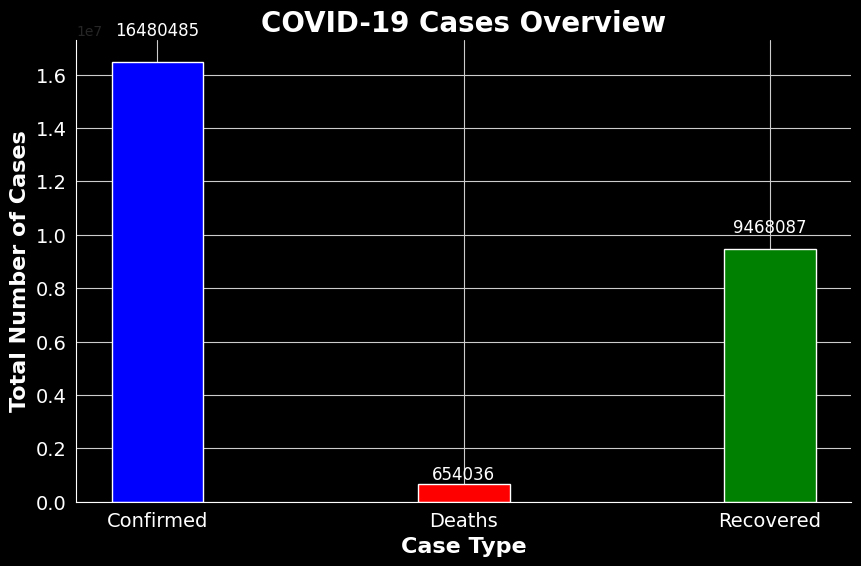

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is your DataFrame
column_names = ['Confirmed', 'Deaths', 'Recovered',]
# Calculate the sum of specified columns
column_sums = data[column_names].sum()

# Define a color palette
colors = ['blue', 'red', 'green', 'purple']  # Blue, Red, Green, Purple

# Plot the bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bar_width = 0.3  # Adjust the width of the bars
bar_plot = plt.bar(column_names, column_sums, color=colors, width=bar_width)

# Set the background color to black
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')

# Add titles and labels with bold font and white color
plt.title('COVID-19 Cases Overview', fontsize=20, fontweight='bold', color='white')
plt.xlabel('Case Type', fontsize=16, fontweight='bold', color='white')
plt.ylabel('Total Number of Cases', fontsize=16, fontweight='bold', color='white')

# Change tick parameters to white
plt.xticks(color='white', fontsize=14)
plt.yticks(color='white', fontsize=14)

# Add value labels on top of the bars
for bar in bar_plot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05*yval, int(yval), ha='center', va='bottom', fontsize=12, color='white')

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')

# Show the plot
plt.show()


Region Wise

In [81]:
import pandas as pd
import plotly.express as px

# Assuming your cleaned data is in a DataFrame called cleaned_data
# Summarize the data by WHO region
summary_data = cleaned_data.groupby('WHO Region').agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}).reset_index()

# Sort summary data by Confirmed cases in descending order
summary_data = summary_data.sort_values(by='Confirmed', ascending=False)

# Define custom color scales for each category
confirmed_color_scale = px.colors.diverging.RdYlBu_r  # Custom color scale for confirmed cases
deaths_color_scale = px.colors.diverging.PuOr_r      # Custom color scale for deaths
recovered_color_scale = px.colors.diverging.RdGy     # Custom color scale for recoveries

# Create a dictionary mapping WHO regions to colors
region_colors = px.colors.qualitative.Set1[:len(summary_data)]

# Create horizontal bar chart for Confirmed cases
fig_confirmed = px.bar(summary_data,
                       x='Confirmed',
                       y='WHO Region',
                       orientation='h',
                       color='WHO Region',
                       title='<b>Total Confirmed Cases by WHO Region</b>',
                       labels={'Confirmed': 'Total Confirmed', 'WHO Region': 'WHO Region'},
                       color_discrete_map={region: color for region, color in zip(summary_data['WHO Region'], region_colors)},
                       template='plotly_dark',  # Black background
                       color_continuous_midpoint=summary_data['Confirmed'].median(),  # Set midpoint for better color distribution
                       )

# Update layout for x and y axis titles to make them bold
fig_confirmed.update_layout(xaxis_title='<b>Total Confirmed</b>', yaxis_title='<b>WHO Region</b>')



# Save the chart as an HTML file
fig_confirmed.write_html('covid19_confirmed_bar_chart.html')


# Create horizontal bar chart for Deaths
fig_deaths = px.bar(summary_data,
                    x='Deaths',
                    y='WHO Region',
                    orientation='h',
                    color='WHO Region',
                    title='<b>Total Deaths by WHO Region</b>',
                    labels={'Deaths': 'Total Deaths', 'WHO Region': 'WHO Region'},
                    color_discrete_map={region: color for region, color in zip(summary_data['WHO Region'], region_colors)},
                    template='plotly_dark',  # Black background
                    color_continuous_midpoint=summary_data['Deaths'].median(),  # Set midpoint for better color distribution
                    )

# Update layout for x and y axis titles to make them bold
fig_deaths.update_layout(xaxis_title='<b>Total Deaths</b>', yaxis_title='<b>WHO Region</b>')



# Save the chart as an HTML file
fig_deaths.write_html('covid19_deaths_bar_chart.html')


# Create horizontal bar chart for Recovered cases
fig_recovered = px.bar(summary_data,
                       x='Recovered',
                       y='WHO Region',
                       orientation='h',
                       color='WHO Region',
                       title='<b>Total Recovered Cases by WHO Region</b>',
                       labels={'Recovered': 'Total Recovered', 'WHO Region': 'WHO Region'},
                       color_discrete_map={region: color for region, color in zip(summary_data['WHO Region'], region_colors)},
                       template='plotly_dark',  # Black background
                       color_continuous_midpoint=summary_data['Recovered'].median(),  # Set midpoint for better color distribution
                       )

# Update layout for x and y axis titles to make them bold
fig_recovered.update_layout(xaxis_title='<b>Total Recovered</b>', yaxis_title='<b>WHO Region</b>')



# Save the chart as an HTML file
fig_recovered.write_html('covid19_recovered_bar_chart.html')


In [82]:
# Create horizontal bar chart for Confirmed cases
fig_confirmed = px.bar(summary_data,
                       x='Confirmed',
                       y='WHO Region',
                       orientation='h',
                       color='WHO Region',
                       title='<b>Total Confirmed Cases wrt Regions</b>',
                       labels={'Confirmed': 'Total Confirmed', 'WHO Region': 'WHO Region'},
                       color_discrete_map={region: color for region, color in zip(summary_data['WHO Region'], region_colors)},
                       template='plotly_dark',  # Black background
                       color_continuous_midpoint=summary_data['Confirmed'].median(),  # Set midpoint for better color distribution
                       )

# Update layout for main title and axis titles to make them bold and adjust their sizes
fig_confirmed.update_layout(title_font_size=20, title_font_family='Arial Black',
                            xaxis_title_font_size=16, xaxis_title_font_family='Arial Black',
                            yaxis_title_font_size=16, yaxis_title_font_family='Arial Black')

# Show the plot
fig_confirmed.show()

# Save the chart as an HTML file
fig_confirmed.write_html('covid19_confirmed_bar_chart.html')


In [84]:
# Create horizontal bar chart for Deaths
fig_deaths = px.bar(summary_data,
                    x='Deaths',
                    y='WHO Region',
                    orientation='h',
                    color='WHO Region',
                    title='<b>Total Deaths by WHO Region</b>',
                    labels={'Deaths': 'Total Deaths', 'WHO Region': 'WHO Region'},
                    color_discrete_map={region: color for region, color in zip(summary_data['WHO Region'], region_colors)},
                    template='plotly_dark',  # Black background
                    color_continuous_midpoint=summary_data['Deaths'].median(),  # Set midpoint for better color distribution
                    )

# Update layout for main title and axis titles to make them bold and adjust their sizes
fig_confirmed.update_layout(title_font_size=20, title_font_family='Arial Black',
                            xaxis_title_font_size=16, xaxis_title_font_family='Arial Black',
                            yaxis_title_font_size=16, yaxis_title_font_family='Arial Black'
                            )

# Show the plot
fig_deaths.show()

# Save the chart as an HTML file
fig_deaths.write_html('covid19_deaths_bar_chart.html')


In [85]:
# Create horizontal bar chart for Recovered cases
fig_recovered = px.bar(summary_data,
                       x='Recovered',
                       y='WHO Region',
                       orientation='h',
                       color='WHO Region',
                       title='<b>Total Recovered Cases by WHO Region</b>',
                       labels={'Recovered': 'Total Recovered', 'WHO Region': 'WHO Region'},
                       color_discrete_map={region: color for region, color in zip(summary_data['WHO Region'], region_colors)},
                       template='plotly_dark',  # Black background
                       color_continuous_midpoint=summary_data['Recovered'].median(),  # Set midpoint for better color distribution
                       )

# Update layout for main title and axis titles to make them bold and adjust their sizes
fig_confirmed.update_layout(title_font_size=20, title_font_family='Arial Black',
                            xaxis_title_font_size=16, xaxis_title_font_family='Arial Black',
                            yaxis_title_font_size=16, yaxis_title_font_family='Arial  Black')

# Show the plot
fig_recovered.show()

# Save the chart as an HTML file
fig_recovered.write_html('covid19_recovered_bar_chart.html')


In [56]:
import pandas as pd
import plotly.express as px

# Assuming your cleaned data is in a DataFrame called cleaned_data
# Summarize the data by WHO region
summary_data = cleaned_data.groupby('WHO Region').agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}).reset_index()

# Melt the data for easier plotting with Plotly
melted_data = summary_data.melt(id_vars='WHO Region', value_vars=['Confirmed', 'Deaths', 'Recovered'],
                                var_name='Case Type', value_name='Count')

# Create the line chart
fig = px.line(melted_data,
              x='WHO Region',
              y='Count',
              color='Case Type',
              markers=True,
              title='Comparison w.r.t WHO Region',
              labels={'Count': 'Total Cases', 'WHO Region': 'WHO Region'})

# Update layout for better aesthetics
fig.update_layout(
    title_font_size=20,  # Set title size to 20
    title_font_family='Arial Black',
    title_font_color='White',
    xaxis_title_font_size=16,  # Set x-axis title size to 16
    xaxis_title_font_family='Arial Black',
    yaxis_title_font_size=16,  # Set y-axis title size to 16
    yaxis_title_font_family='Arial Black',
    legend_title_text='Case Type',
    legend_title_font_size=12,  # Adjust legend title size
    legend_title_font_family='Arial Black'
)

# Show the plot
fig.show()


In [57]:
import pandas as pd
import plotly.express as px

# Assuming your cleaned data is in a DataFrame called cleaned_data
# Summarize the data by WHO region
summary_data = cleaned_data.groupby('WHO Region').agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}).reset_index()

# Sort the summary data by the total number of confirmed cases in descending order
summary_data = summary_data.sort_values(by='Confirmed', ascending=False)

# Melt the data for easier plotting with Plotly
melted_data = summary_data.melt(id_vars='WHO Region', value_vars=['Confirmed', 'Deaths', 'Recovered'],
                                var_name='Case Type', value_name='Total Cases')

# Create a histogram
fig = px.histogram(melted_data,
                   y='Total Cases',
                   x='WHO Region',
                   color='Case Type',
                   barmode='group',
                   histfunc='sum',
                   category_orders={'WHO Region': summary_data['WHO Region']},
                   labels={'Total Cases': 'Total Cases', 'WHO Region': 'WHO Region'},
                   height=600)

# Update layout for better aesthetics and set the title
fig.update_layout(
    title_text='Comparison of COVID-19 Cases w.r.t to WHO Regions',  # Set the title
    title_font_size=20,  # Set title size to 20
    title_font_family='Arial Black',
    title_font_color='black',  # Change title font color to black for better visibility
    legend_title_text='Case Type',
    legend_title_font_size=16,
    legend_title_font_family='Arial Black',
    xaxis_title='WHO Region',  # Set x-axis title
    yaxis_title='Total Cases',  # Set y-axis title
    xaxis_title_font_size=16,
    xaxis_title_font_family='Arial Black',
    yaxis_title_font_size=16,
    yaxis_title_font_family='Arial Black'
)

# Show the plot
fig.show()


In [58]:
import pandas as pd
import plotly.express as px

# Assuming your cleaned data is in a DataFrame called cleaned_data
# Summarize the data by WHO region and case type
summary_data = cleaned_data.groupby(['WHO Region']).agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}).reset_index()

# Melt the data for easier plotting with Plotly
melted_data = summary_data.melt(id_vars='WHO Region', value_vars=['Confirmed', 'Deaths', 'Recovered'],
                                var_name='Case Type', value_name='Count')

# Create the sunburst chart
fig = px.sunburst(melted_data,
                  path=['WHO Region', 'Case Type'],
                  values='Count',
                  color='Case Type',
                  color_discrete_map={'Confirmed': 'blue', 'Deaths': 'red', 'Recovered': 'green'},
                 )

# Update layout for better aesthetics
fig.update_layout(title_font_size=24, title_font_family='Arial Black', title_font_color='white')


# Update layout for better aesthetics
fig.update_layout(
    title_font_size=20,
    title_font_family='Arial Black',
    title_font_color='white',
    xaxis_title_font_size=16,
    xaxis_title_font_family='Arial Black',
    yaxis_title_font_size=16,
    yaxis_title_font_family='Arial Black',
    plot_bgcolor='black'  # Keeping the background color white as specified
)
# Show the plot
fig.show()

# Save the chart as an HTML file
fig.write_html('covid19_sunburst_chart.html')


Country wise

In [59]:
import plotly.express as px

fig = px.bar(data.sort_values('Confirmed', ascending=False)[:20][::-1],
             x='Confirmed', y='Country',
             title='Worldwide Confirmed Cases', text='Confirmed', height=1000, orientation='h')
# Update layout for better aesthetics
fig.update_layout(
    title_font_size=20,
    title_font_family='Arial Black',
    title_font_color='white',
    xaxis_title_font_size=16,
    xaxis_title_font_family='Arial Black',
    yaxis_title_font_size=16,
    yaxis_title_font_family='Arial Black',
    plot_bgcolor='black'  # Keeping the background color white as specified
)

fig.show()


In [60]:
import plotly.express as px

fig = px.bar(data.sort_values('Deaths', ascending=False)[:20][::-1],
             x='Deaths', y='Country',
             title='Countrywise Deaths Cases', text='Deaths', height=1000, orientation='h')
# Update layout for better aesthetics
fig.update_layout(
    title_font_size=20,
    title_font_family='Arial Black',
    title_font_color='white',
    xaxis_title_font_size=16,
    xaxis_title_font_family='Arial Black',
    yaxis_title_font_size=16,
    yaxis_title_font_family='Arial Black',
    plot_bgcolor='black'  # Keeping the background color white as specified
)

fig.show()

In [61]:
import plotly.express as px

fig = px.bar(data.sort_values('Recovered', ascending=False)[:20][::-1],
             x='Recovered', y='Country',
             title='Countrywise Recovered Cases', text='Recovered', height=1000, orientation='h')
# Update layout for better aesthetics
fig.update_layout(
    title_font_size=20,
    title_font_family='Arial Black',
    title_font_color='white',
    xaxis_title_font_size=16,
    xaxis_title_font_family='Arial Black',
    yaxis_title_font_size=16,
    yaxis_title_font_family='Arial Black',
    plot_bgcolor='black'  # Keeping the background color white as specified
)

fig.show()

In [62]:
pip install squarify

In [63]:
import pandas as pd
import plotly.express as px

# Assuming your cleaned data is in a DataFrame called cleaned_data
# Summarize the data by country
summary_data = cleaned_data.groupby('Country').agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}).reset_index()

# Define the size of the bubbles based on the 'Confirmed' cases
summary_data['size'] = summary_data['Confirmed']

# Create the packed bubble chart using Plotly
fig = px.scatter(summary_data,
                 x='Deaths',
                 y='Recovered',
                 size='size',
                 color='Country',  # Assign different colors to each country
                 hover_name='Country',
                 size_max=60,
                 labels={'Deaths':'Total Deaths', 'Recovered':'Total Recovered'},
                 title='COVID-19 Overview by Countrywise')

# Update the layout for better aesthetics
fig.update_layout(
    title_font_size=20,
    title_font_family='Arial Black',
    title_font_color='white',
    xaxis_title_font_size=16,
    xaxis_title_font_family='Arial Black',
    yaxis_title_font_size=16,
    yaxis_title_font_family='Arial Black',
    plot_bgcolor='black'
)

fig.show()


Cases Over Time

In [64]:
# Group data by date and country for confirmed cases
grouped_data_confirmed = cleaned_data.groupby(['Date', 'Country'])[['Confirmed']].sum().reset_index()

# Get the top 15 countries with the highest total confirmed cases
top_countries_confirmed = grouped_data_confirmed.groupby('Country')['Confirmed'].sum().nlargest(15).index

# Filter the data for the top 15 countries
grouped_top_countries_confirmed = grouped_data_confirmed[grouped_data_confirmed['Country'].isin(top_countries_confirmed)]

# Create the race bar chart for confirmed cases over time
fig_confirmed = px.bar(grouped_top_countries_confirmed,
                       x='Confirmed',
                       y='Country',
                       animation_frame='Date',
                       orientation='h',
                       title='COVID-19 Confirmed Cases Over Time',
                       labels={'Confirmed': 'Total Confirmed Cases', 'Country': 'Country'},
                       height=600,
                       text='Confirmed',  # Show number of confirmed cases on the tip of each bar
                       hover_name='Country',  # Show country name on hover
                      )

# Customize the layout for confirmed cases
fig_confirmed.update_layout(
    title_font_size=24,
    title_font_family='Arial Black',
    title_font_color='white',
    xaxis_title_font_size=16,
    xaxis_title_font_family='Arial Black',
    yaxis_title_font_size=16,
    yaxis_title_font_family='Arial Black',
    plot_bgcolor='black',
    showlegend=False,  # Do not show the color scale legend
    yaxis=dict(categoryorder='total ascending'),  # Ensure bars are in proper order
      width=1800,  # Set the width of the figure
    height=800,  # Set the height of the figure
)

# Increase bar size for better visualization
fig_confirmed.update_traces(marker=dict(line=dict(width=2)))  # Adjust width of the bars

# Show the plot for confirmed cases
fig_confirmed.show()


In [65]:
import pandas as pd
import plotly.express as px

# Ensure 'Date' is in datetime format
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'])

# Group data by date and country
grouped_data = cleaned_data.groupby(['Date', 'Country'])[['Deaths']].sum().reset_index()

# Get the top 15 countries with the highest total deaths
top_countries = grouped_data.groupby('Country')['Deaths'].sum().nlargest(15).index

# Filter the data for the top 15 countries
grouped_top_countries = grouped_data[grouped_data['Country'].isin(top_countries)]

# Create the race bar chart for deaths over time
fig = px.bar(grouped_top_countries,
             x='Deaths',
             y='Country',
             animation_frame='Date',
             orientation='h',
             title='COVID-19 Deaths Over Time',
             labels={'Deaths': 'Total Deaths', 'Country': 'Country'},
             height=600,
             text='Deaths',  # Show number of deaths on the tip of each bar
             hover_name='Country',  # Show country name on hover
            )

# Customize the layout
fig.update_layout(
    title_font_size=24,
    title_font_family='Arial Black',
    title_font_color='white',
    xaxis_title_font_size=16,
    xaxis_title_font_family='Arial Black',
    yaxis_title_font_size=16,
    yaxis_title_font_family='Arial Black',
    plot_bgcolor='black',
    showlegend=False,  # Do not show the color scale legend
    yaxis=dict(categoryorder='total ascending'),  # Ensure bars are in proper order
     width=1800,  # Set the width of the figure
    height=800,  # Set the height of the figure
)

# Increase bar size for better visualization
fig.update_traces(marker=dict(line=dict(width=2)))  # Adjust width of the bars

# Show the plot
fig.show()


In [66]:
import pandas as pd
import plotly.express as px

# Ensure 'Date' is in datetime format
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'])

# Group data by date and country
grouped_data = cleaned_data.groupby(['Date', 'Country'])[['Recovered']].sum().reset_index()

# Get the top 15 countries with the highest total recovered cases
top_countries = grouped_data.groupby('Country')['Recovered'].sum().nlargest(15).index

# Filter the data for the top 15 countries
grouped_top_countries = grouped_data[grouped_data['Country'].isin(top_countries)]

# Create the race bar chart for recovered cases over time
fig_recovered = px.bar(grouped_top_countries,
                        x='Recovered',
                        y='Country',
                        animation_frame='Date',
                        orientation='h',
                        title='COVID-19 Recovered Cases Over Time',
                        labels={'Recovered': 'Total Recovered Cases', 'Country': 'Country'},
                        height=600,
                        text='Recovered',  # Show number of recovered cases on the tip of each bar
                        hover_name='Country',  # Show country name on hover
                       )

# Customize the layout for recovered cases
fig_recovered.update_layout(
    title_font_size=24,
    title_font_family='Arial Black',
    title_font_color='white',
    xaxis_title_font_size=16,
    xaxis_title_font_family='Arial Black',
    yaxis_title_font_size=16,
    yaxis_title_font_family='Arial Black',
    plot_bgcolor='black',
    showlegend=False,  # Do not show the color scale legend
    yaxis=dict(categoryorder='total ascending'),  # Ensure bars are in proper order
      width=1800,  # Set the width of the figure
    height=800,  # Set the height of the figure
)


# Increase bar size for better visualization
fig_recovered.update_traces(marker=dict(line=dict(width=4)))  # Adjust width of the bars

# Show the plot for recovered cases
fig_recovered.show()


In [67]:
temp = cleaned_data.groupby('Date')[['Recovered', 'Deaths', 'Confirmed']].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Confirmed'],
                 var_name='case', value_name='count')

# Line Chart
fig_line = px.line(temp, x="Date", y="count", color='case',
                   title='Cases Over Time: Line Chart', color_discrete_sequence=['cyan', 'blue', 'orange'])

# Update layout for main title and axis titles to make them bold and adjust their sizes
fig_line.update_layout(title_font_size=20, title_font_family='Arial Black',
                       xaxis_title_font_size=16, xaxis_title_font_family='Arial Black',
                       yaxis_title_font_size=16, yaxis_title_font_family='Arial Black')

fig_line.show()

# Area Chart
fig_area = px.area(temp, x="Date", y="count", color='case',
                   title='Cases Over Time: Area Chart', color_discrete_sequence=['cyan', 'blue', 'orange'])

# Update layout for main title and axis titles to make them bold and adjust their sizes
fig_area.update_layout(title_font_size=20, title_font_family='Arial Black',
                       xaxis_title_font_size=16, xaxis_title_font_family='Arial Black',
                       yaxis_title_font_size=16, yaxis_title_font_family='Arial Black')

fig_area.show()


In [68]:
# Data group for China
grouped_china = cleaned_data[cleaned_data['Country'] == "China"].reset_index()
grouped_china_date = grouped_china.groupby('Date')[['Confirmed', 'Deaths']].sum().reset_index()

# Data group for Turkey
grouped_turkey = cleaned_data[cleaned_data['Country'] == "Turkey"].reset_index()
grouped_turkey_date = grouped_turkey.groupby('Date')[['Confirmed', 'Deaths']].sum().reset_index()

# Data group for the US
grouped_us = cleaned_data[cleaned_data['Country'] == "US"].reset_index()
grouped_us_date = grouped_us.groupby('Date')[['Confirmed', 'Deaths']].sum().reset_index()

# Data group for other countries
grouped_rest = cleaned_data[~cleaned_data['Country'].isin(['China', 'Turkey', 'US'])].reset_index()
grouped_rest_date = grouped_rest.groupby('Date')[['Confirmed', 'Deaths']].sum().reset_index()


In [69]:
cleaned_data.sort_values(by="Deaths", ascending=False).head()


,State,Country,Latitude,Longitude,Date,Confirmed,Deaths,Recovered,Active,WHO Region,Active Status
49030,,US,40,-100,2020-07-27,4290259,148011,1325804,2816444,Americas,2816444
48769,,US,40,-100,2020-07-26,4233923,146935,1297863,2789125,Americas,2789125
48508,,US,40,-100,2020-07-25,4178970,146465,1279414,2753091,Americas,2753091
48247,,US,40,-100,2020-07-24,4112531,145560,1261624,2705347,Americas,2705347
47986,,US,40,-100,2020-07-23,4038816,144430,1233269,2661117,Americas,2661117


In [70]:
data.sample(1)

,Country,Confirmed,Deaths,Recovered,Active,New Cases,New Deaths,New Recovered,Deaths (per 100 Cases),Recovered (per 100 Cases),Deaths (per 100 Recovered),Confirmed last week,1 week change,1 week % increase,WHO Region
174,Uganda,1128,2,986,140,13,0,4,0,87,0,1069,59,6,Africa


Confirmed Deaths Over Time

In [71]:
import plotly.express as px

fig = px.choropleth(data,
                    locations="Country",
                    locationmode='country names',  # Set the location mode to country names
                    color="Deaths",
                    hover_name="Country",  # Set the text to be displayed when hovering over to country names
                    range_color=[1, 10000],
                    color_continuous_scale="peach")

fig.update_layout(
    title=dict(text='Countries with Reported Deaths', font=dict(size=20, family='Arial Black')),
    coloraxis_colorbar=dict(title=dict(text='Deaths', font=dict(size=16, family='Arial Black'))),
)

fig.show()


In [72]:
fig = px.choropleth(data,
                    locations="Country",
                    locationmode='country names',
                    color="Deaths",
                    hover_name="Country",
                    range_color=[1,10000],
                    color_continuous_scale='portland',
                    title='European Countries with Deaths',
                    scope='europe',
                    height=800)

fig.update_layout(
    title=dict(text='Europian Countries with Reported Deaths', font=dict(size=20, family='Arial Black')),
    coloraxis_colorbar=dict(title=dict(text='Deaths', font=dict(size=16, family='Arial Black'))),
)
fig.show()


In [73]:
data.sample(1)

,Country,Confirmed,Deaths,Recovered,Active,New Cases,New Deaths,New Recovered,Deaths (per 100 Cases),Recovered (per 100 Cases),Deaths (per 100 Recovered),Confirmed last week,1 week change,1 week % increase,WHO Region
137,Romania,45902,2206,25794,17902,1104,19,151,5,56,9,38139,7763,20,Europe


In [74]:
cleaned_data.sample(1)

,State,Country,Latitude,Longitude,Date,Confirmed,Deaths,Recovered,Active,WHO Region,Active Status
4450,Tasmania,Australia,-43,147,2020-02-08,0,0,0,0,Western Pacific,0


Worldwide Analysis
COVID-19: Time Spread

In [75]:
formated_gdf = cleaned_data.groupby(['Date', 'Country'])[['Confirmed', 'Deaths']].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])  # Convert "Date" column to datetime format
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')  # Convert "Date" column to a specific format
formated_gdf['size'] = formated_gdf['Confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country", locationmode='country names',
                     color="Confirmed", size='size', hover_name="Country",
                     range_color=[0, 100],
                     projection="natural earth", animation_frame="Date",
                     title='COVID-19: Spread Over Time', color_continuous_scale="portland")
fig.update_layout(
    title=dict(text='Spreadness of COVID', font=dict(size=20, family='Arial Black')),
    coloraxis_colorbar=dict(title=dict(text='Deaths', font=dict(size=16, family='Arial Black'))),
)
# fig.update_layout(coloraxis_showscale=False)
fig.show()


In [76]:
from IPython.display import IFrame

# Define the URL of the web page you want to embed
url = "https://covidvisualizer.com/"

# Set the figure size to be square (500x500)
width = 1200
height = 800

# Create and display the IFrame
IFrame(src=url, width=width, height=height)



In [86]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import os

# Create a directory to save all the figures
output_dir = "figures"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to save Matplotlib figures
def save_matplotlib_figure(fig, filename):
    fig.savefig(os.path.join(output_dir, filename))
    plt.close(fig)

# Function to save Plotly figures
def save_plotly_figure(fig, filename):
    pio.write_html(fig, file=os.path.join(output_dir, filename), auto_open=False)



print("All figures have been saved.")


All figures have been saved.
